In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm


from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.MIPS import MIPS
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

import obp
from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [4]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/11 13:44:58 WARN Utils: Your hostname, hdilab-hdilabALIEN05 resolves to a loopback address: 127.0.1.1; using 172.21.136.110 instead (on interface enp3s0)
24/09/11 13:44:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/11 13:44:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/11 13:44:59 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [5]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
dataset = MovielensBanditDataset(data)

11-Sep-24 13:45:05, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


11-Sep-24 13:45:11, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
11-Sep-24 13:45:12, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


fit started
predict started


100%|██████████| 1000209/1000209 [02:45<00:00, 6052.06it/s]


In [7]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

100%|██████████| 111054/111054 [00:18<00:00, 6126.72it/s]


700144
111054


In [8]:
bandit_feedback_train.keys()

dict_keys(['log', 'item_features', 'user_features', 'n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

The keys of the dictionary are as follows.
- n_rounds: number of rounds, data size of the logged bandit data;
- n_actions: number of actions $|\mathcal{A}|$;
- action: action variables sampled by the behavior policy;
- position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface;
- reward: binary reward variables, click indicators;
- pscore: action choice probabilities by the behavior policy, propensity scores;
- context: context vectors such as user-related features and user-item affinity scores;
- action_context: item-related context vectors

In [9]:
#Define replay model
model_1 = UCB(exploration_coef = 2.0, sample = True, seed = 123)
model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
model_3 = RandomRec(seed=42)

#Define learner which connects OBP data format with replay
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user

learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3,
                                    len_list=dataset.len_list,)

**RePlayOfflinePolicyLearner** has the following methods
- *fit(action, reward, timestamp, context, action_context)*;
- *predict(n_rounds, context)* (context can be None thus n_rounds is **required**);
- *optimize(bandit_feedback, val_size, param_borders, criterion, budget, new_study)*

In [10]:
#Fit replay model inside our learner
learner_1.fit(bandit_feedback_train)
learner_2.fit(bandit_feedback_train)
learner_3.fit(bandit_feedback_train)

In [11]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(dataset.n_actions,
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

When we get distribution over actions - we can run any evaluation procedure from the OBP. Here we use three estimators
- *IPW*: Average rewards with importance weights
- *DM*: Average predicted rewards using the classifier
- *DR*: Combination of the above methods with zero bias and lower variance

Also, we can construct confidence intervals for each of these methods.

In [12]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], dataset.n_actions, dataset.len_list))
    if isinstance(learner.replay_model, (LinUCB)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 100
        num_batchs = log_distinct.shape[0] // batch_size + 1
        for i in tqdm(range(num_batchs)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            log_subset = log_distinct.iloc[i*batch_size: j]
            n_rounds = log_subset.shape[0]
            
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size + 1
        for i in tqdm(range(num_batchs)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[i*batch_size:j, :, :] = action_dist
    return all_action_dist

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
#Predict distribution over actions: shape (n_rounds, n_actions, len_list)
import time
start = time.time()
learner_action_dist_1 = get_dist(learner_1)
print(time.time() - start)

start = time.time()
learner_action_dist_2 = get_dist(learner_2)
print(time.time() - start)

start = time.time()
learner_action_dist_3 = get_dist(learner_3)
print(time.time() - start)

  0%|          | 0/371 [00:00<?, ?it/s]

100%|██████████| 371/371 [01:02<00:00,  5.91it/s]


62.828288078308105


100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


5.006695032119751


100%|██████████| 371/371 [00:56<00:00,  6.60it/s]

56.23413920402527


In [15]:
def run_exp(learner_action_dist):
    Vs = []
    CIs = []

    # for n_size in [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]:
    for n_size in [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]:
    # for n_size in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, bandit_feedback_test["n_rounds"]]:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :, :]
        
        action_dist = learner_action_dist[:n_size, :, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=10000,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [16]:
Vs_1, CIs_1 = run_exp(learner_action_dist_1)

n_size = 10000 time:  5.7329137325286865
n_size = 20000 time:  10.651925563812256
n_size = 30000 time:  8.677132368087769
n_size = 40000 time:  20.615114450454712
n_size = 50000 time:  18.520578145980835
n_size = 60000 time:  16.464531898498535
n_size = 70000 time:  41.7125678062439
n_size = 80000 time:  40.67445707321167
n_size = 90000 time:  39.627073526382446
n_size = 100000 time:  39.22097659111023
n_size = 111054 time:  39.11586403846741


In [17]:
Vs_2, CIs_2 = run_exp(learner_action_dist_2)

n_size = 10000 time:  5.8824708461761475
n_size = 20000 time:  10.92566180229187
n_size = 30000 time:  9.027941703796387
n_size = 40000 time:  21.20951271057129
n_size = 50000 time:  19.033238649368286
n_size = 60000 time:  16.88042449951172
n_size = 70000 time:  42.53915452957153
n_size = 80000 time:  40.67963671684265
n_size = 90000 time:  38.7213249206543
n_size = 100000 time:  36.55362606048584
n_size = 111054 time:  36.82816028594971


In [18]:
Vs_3, CIs_3 = run_exp(learner_action_dist_3)

n_size = 10000 time:  5.830109119415283
n_size = 20000 time:  10.789554834365845
n_size = 30000 time:  8.826457500457764
n_size = 40000 time:  20.903069972991943
n_size = 50000 time:  19.07359027862549
n_size = 60000 time:  17.48113775253296
n_size = 70000 time:  42.52827978134155
n_size = 80000 time:  40.74148893356323
n_size = 90000 time:  39.4479341506958
n_size = 100000 time:  37.48648953437805
n_size = 111054 time:  34.570796489715576


In [19]:
import matplotlib.pyplot as plt
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(4, figsize=(10, 10))

    # x = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, bandit_feedback_test["n_rounds"]]
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

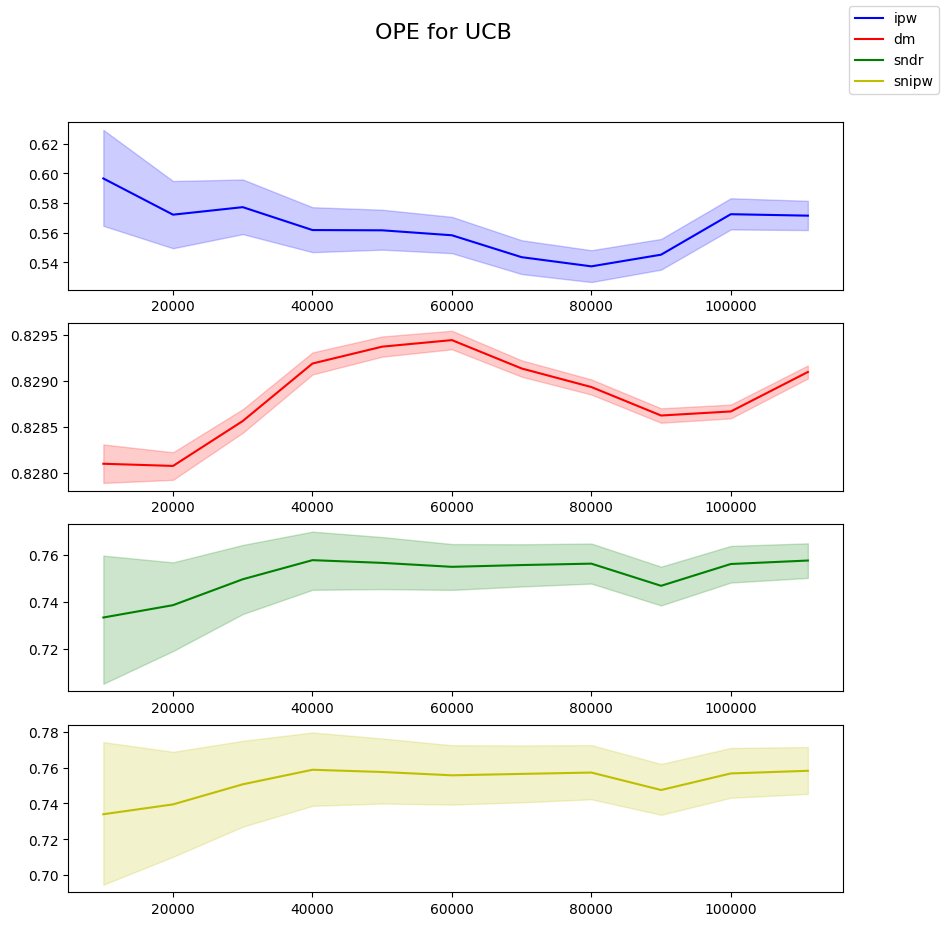

In [20]:
plot_disjoint_res(Vs_1, CIs_1, 'UCB')

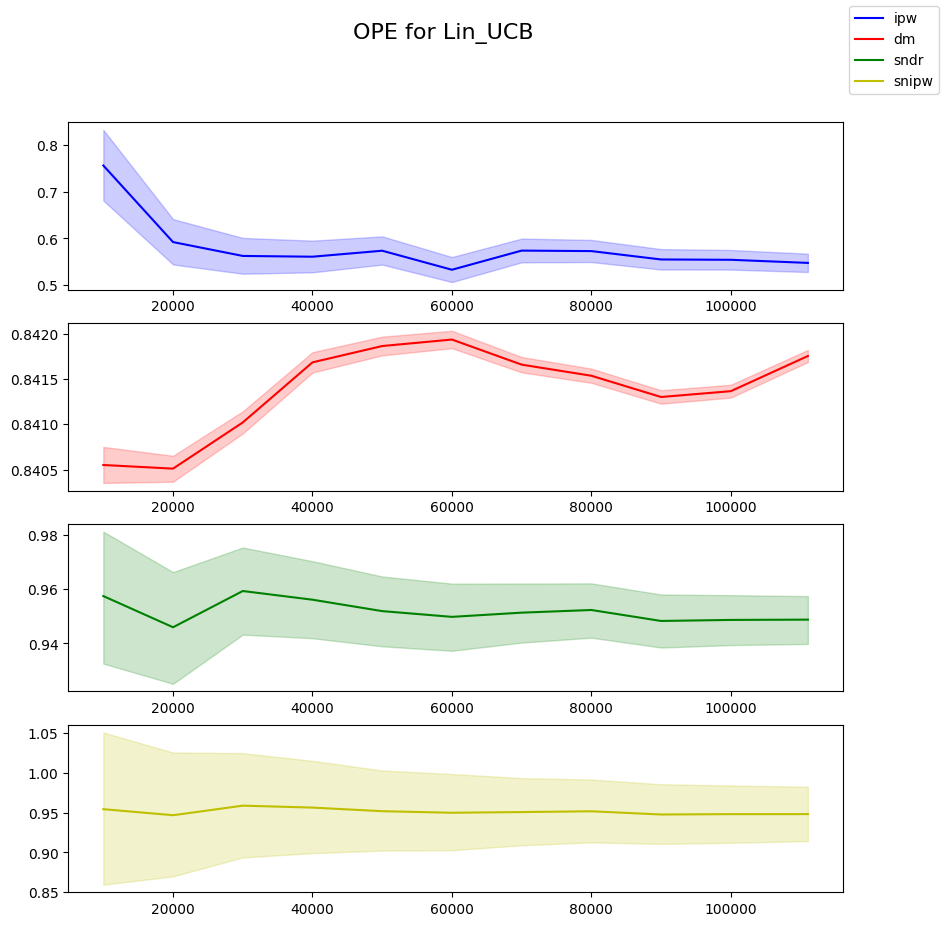

In [21]:
plot_disjoint_res(Vs_2, CIs_2, 'Lin_UCB')

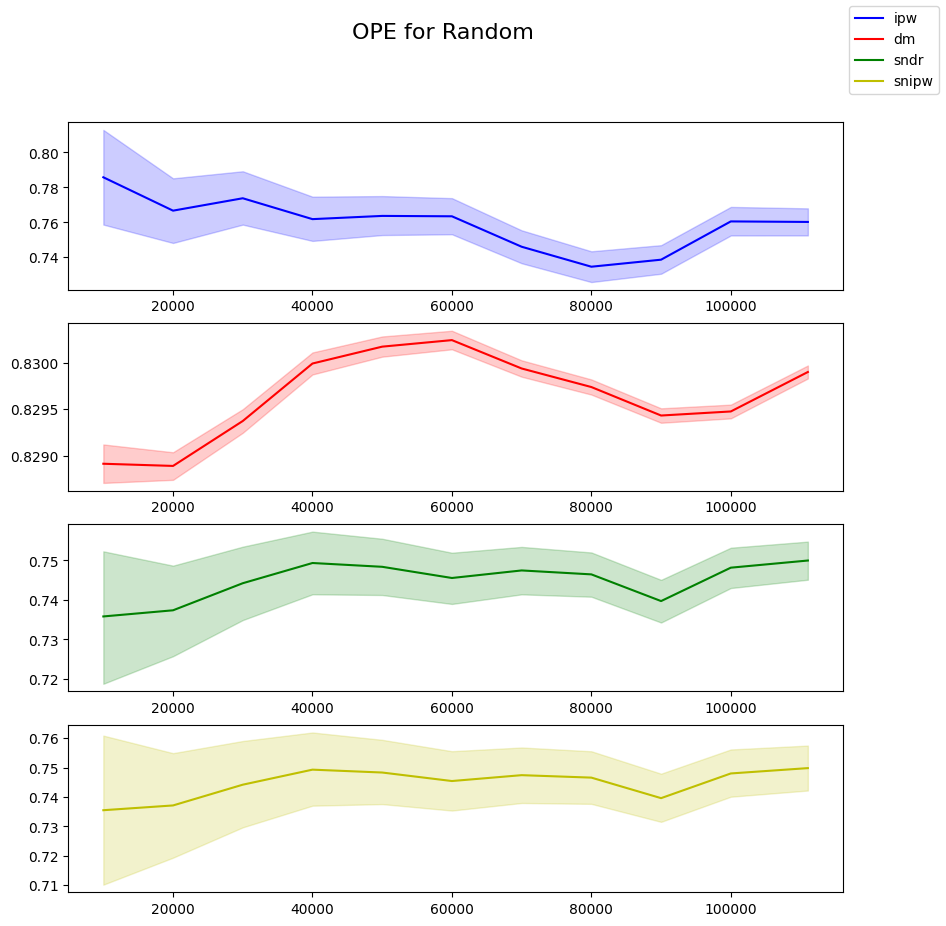

In [22]:
plot_disjoint_res(Vs_3, CIs_3, 'Random')

In [23]:
out_str = f"Scores for UCB true"
for key, val in Vs_1[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for UCB true ipw : 571.548, dm : 829.095, sndr : 757.724, snipw : 758.297


In [24]:
out_str = f"Scores for Lin_UCB true"
for key, val in Vs_2[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for Lin_UCB true ipw : 546.974, dm : 841.753, sndr : 948.683, snipw : 948.042


In [25]:
out_str = f"Scores for random true"
for key, val in Vs_3[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for random true ipw : 760.234, dm : 829.902, sndr : 749.971, snipw : 749.835


In [26]:
print("USB all")
print(Vs_1)

USB all
[{'ipw': 0.5966019498071081, 'dm': 0.8281009804634315, 'sndr': 0.7335435257910361, 'snipw': 0.7341096539065839}, {'ipw': 0.572100906018389, 'dm': 0.8280776213253379, 'sndr': 0.7387506352698857, 'snipw': 0.7394489956318313}, {'ipw': 0.5771858059527321, 'dm': 0.8285639145596152, 'sndr': 0.7497449225058922, 'snipw': 0.7506636040657426}, {'ipw': 0.5617985807778835, 'dm': 0.8291871516972115, 'sndr': 0.7579164720325015, 'snipw': 0.7588065521618914}, {'ipw': 0.561641980809579, 'dm': 0.8293693550504165, 'sndr': 0.7567270750529463, 'snipw': 0.7575805356228124}, {'ipw': 0.5582708142802849, 'dm': 0.8294399668576314, 'sndr': 0.7550140020864886, 'snipw': 0.7556920900964127}, {'ipw': 0.5435748477346406, 'dm': 0.8291333718256377, 'sndr': 0.7558064785224837, 'snipw': 0.7565302441769756}, {'ipw': 0.5374417759127534, 'dm': 0.8289324542756049, 'sndr': 0.7564046106301283, 'snipw': 0.7573395810786555}, {'ipw': 0.545282019645807, 'dm': 0.8286240716050323, 'sndr': 0.7469507036673905, 'snipw': 0.74759

In [27]:
print("Lin USB all")
print(Vs_2)

Lin USB all
[{'ipw': 0.756924393867465, 'dm': 0.8405504205263252, 'sndr': 0.9572579253200485, 'snipw': 0.955004825195835}, {'ipw': 0.5918404050957057, 'dm': 0.8405102539037671, 'sndr': 0.945908287458055, 'snipw': 0.9468124479889101}, {'ipw': 0.5618457480688663, 'dm': 0.8410194966255216, 'sndr': 0.9592431368841075, 'snipw': 0.958532918710621}, {'ipw': 0.5601211135376288, 'dm': 0.8416829923481706, 'sndr': 0.9561415092488669, 'snipw': 0.95598201441028}, {'ipw': 0.5729426747676729, 'dm': 0.841862655706318, 'sndr': 0.9518942845684724, 'snipw': 0.9513522314550658}, {'ipw': 0.5320389043022711, 'dm': 0.8419341128138399, 'sndr': 0.9497930754526003, 'snipw': 0.9493950963182638}, {'ipw': 0.573399772393995, 'dm': 0.8416577905904358, 'sndr': 0.9512780425642782, 'snipw': 0.9506149127597654}, {'ipw': 0.5723247366956697, 'dm': 0.8415352178144591, 'sndr': 0.952246221977686, 'snipw': 0.9515739905958935}, {'ipw': 0.5543520209857802, 'dm': 0.8413008436894646, 'sndr': 0.9481995767064538, 'snipw': 0.9475510

In [28]:
print("Random all")
print(Vs_3)

Random all
[{'ipw': 0.7859086391357292, 'dm': 0.8289117117839574, 'sndr': 0.7358614032985956, 'snipw': 0.7355780635364922}, {'ipw': 0.7666721126650856, 'dm': 0.8288884316661893, 'sndr': 0.73736534096462, 'snipw': 0.7370948823215198}, {'ipw': 0.773806460478288, 'dm': 0.8293728422861496, 'sndr': 0.7442044323956643, 'snipw': 0.744192532017899}, {'ipw': 0.7618029224498468, 'dm': 0.8299936621236298, 'sndr': 0.7493673871875483, 'snipw': 0.7492750693864172}, {'ipw': 0.76366333367638, 'dm': 0.8301751437222179, 'sndr': 0.7483868534240548, 'snipw': 0.7483088979352029}, {'ipw': 0.7634239685609595, 'dm': 0.8302454672953695, 'sndr': 0.745526925402886, 'snipw': 0.7453919821881504}, {'ipw': 0.7460086815222104, 'dm': 0.8299400408608871, 'sndr': 0.7474740655402773, 'snipw': 0.7474185711681026}, {'ipw': 0.7345904429428772, 'dm': 0.8297398994784637, 'sndr': 0.7464696607355565, 'snipw': 0.7466078535585927}, {'ipw': 0.738610785776644, 'dm': 0.8294326818938599, 'sndr': 0.7396803505295821, 'snipw': 0.7396087

In [29]:
print("Estimated confidence intervals UCB:")
print(pd.DataFrame(CIs_1[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(CIs_2[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(CIs_3[-1]).to_string())

Estimated confidence intervals UCB:
                       ipw        dm      sndr     snipw
mean              0.571459  0.829094  0.757720  0.758178
95.0% CI (lower)  0.561745  0.829024  0.750305  0.745291
95.0% CI (upper)  0.581443  0.829165  0.765049  0.771425
Estimated confidence intervals Lin UCB:
                       ipw        dm      sndr     snipw
mean              0.546969  0.841752  0.948754  0.948033
95.0% CI (lower)  0.527385  0.841685  0.939773  0.914090
95.0% CI (upper)  0.566842  0.841819  0.957425  0.982479
Estimated confidence intervals Random:
                       ipw        dm      sndr     snipw
mean              0.760199  0.829901  0.749983  0.749800
95.0% CI (lower)  0.752464  0.829831  0.745110  0.742171
95.0% CI (upper)  0.767984  0.829972  0.754783  0.757478


In [49]:
print(Vs_1[-1])
print(Vs_2[-1])
print(Vs_3[-1])

{'ipw': 0.5715481240415263, 'dm': 0.8290953295693756, 'sndr': 0.7577241114445916, 'snipw': 0.7582970282159053}
{'ipw': 0.5469736094906388, 'dm': 0.8417528098637522, 'sndr': 0.9486831094859931, 'snipw': 0.9480415407594662}
{'ipw': 0.7602338042144501, 'dm': 0.8299021526201135, 'sndr': 0.7499709433271564, 'snipw': 0.7498346856523201}


In [32]:
def plot_res_two_politics(CIs_p1, CIs_p2, model_p1, model_p2):
    fig, ax = plt.subplots(4, figsize=(15, 10))
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i=0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p1]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p1]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p1]

        ax[i].plot(x, y_est, '-', label=model_p1+"_"+name, color = colors[0])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p2]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p2]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p2]

        ax[i].plot(x, y_est, '-', label=model_p2+"_"+name, color = colors[1])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
        ax[i].set_title(name)
        
        i = i+1
    fig.suptitle("OPE for " + model_p1 + " and " + model_p2, fontsize=16)
    fig.legend()

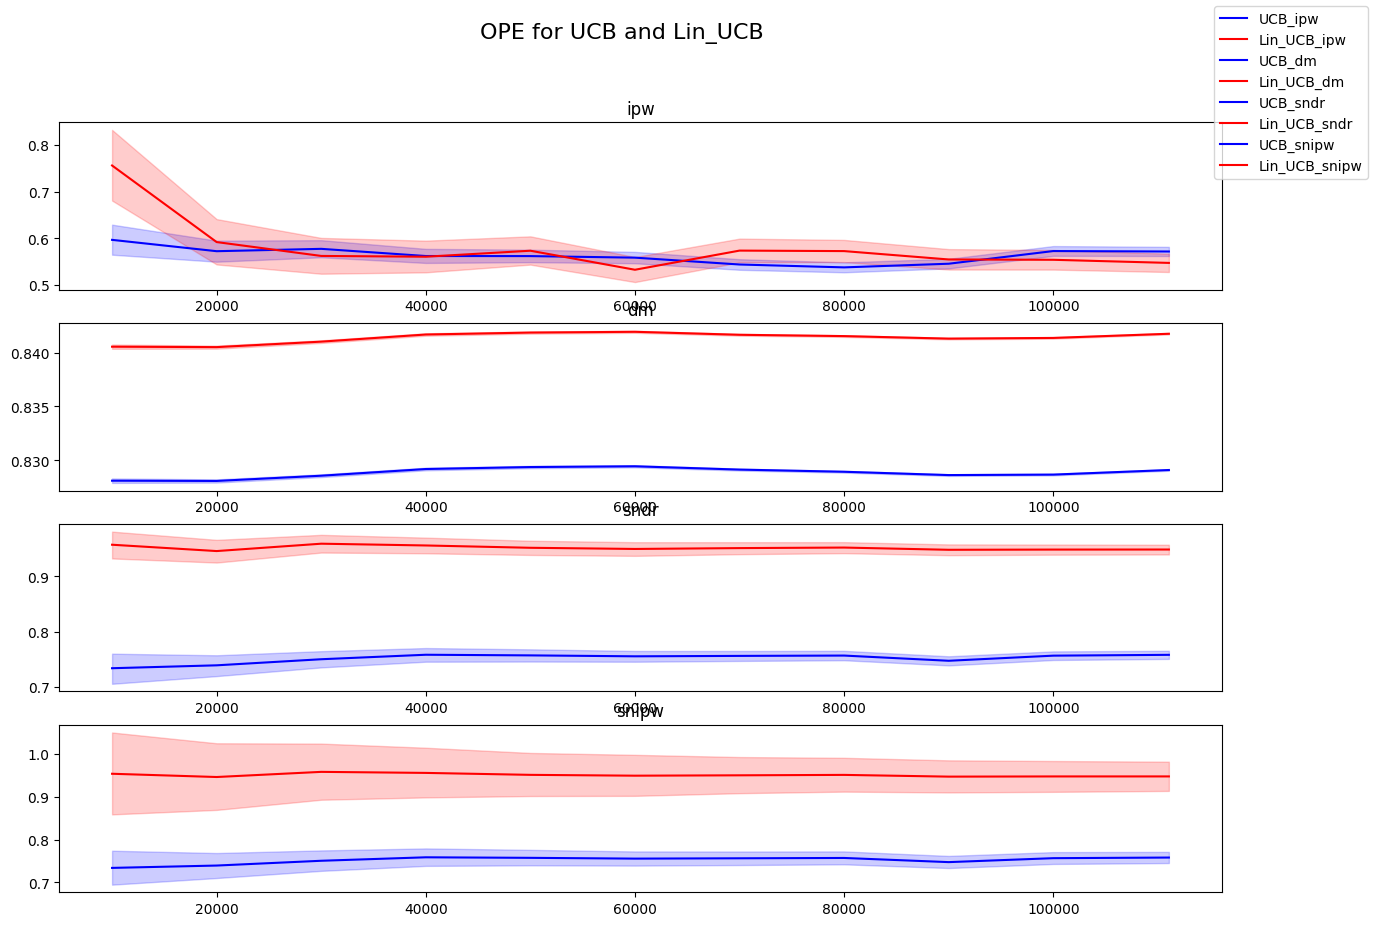

In [33]:
plot_res_two_politics(CIs_1, CIs_2, "UCB", "Lin_UCB")

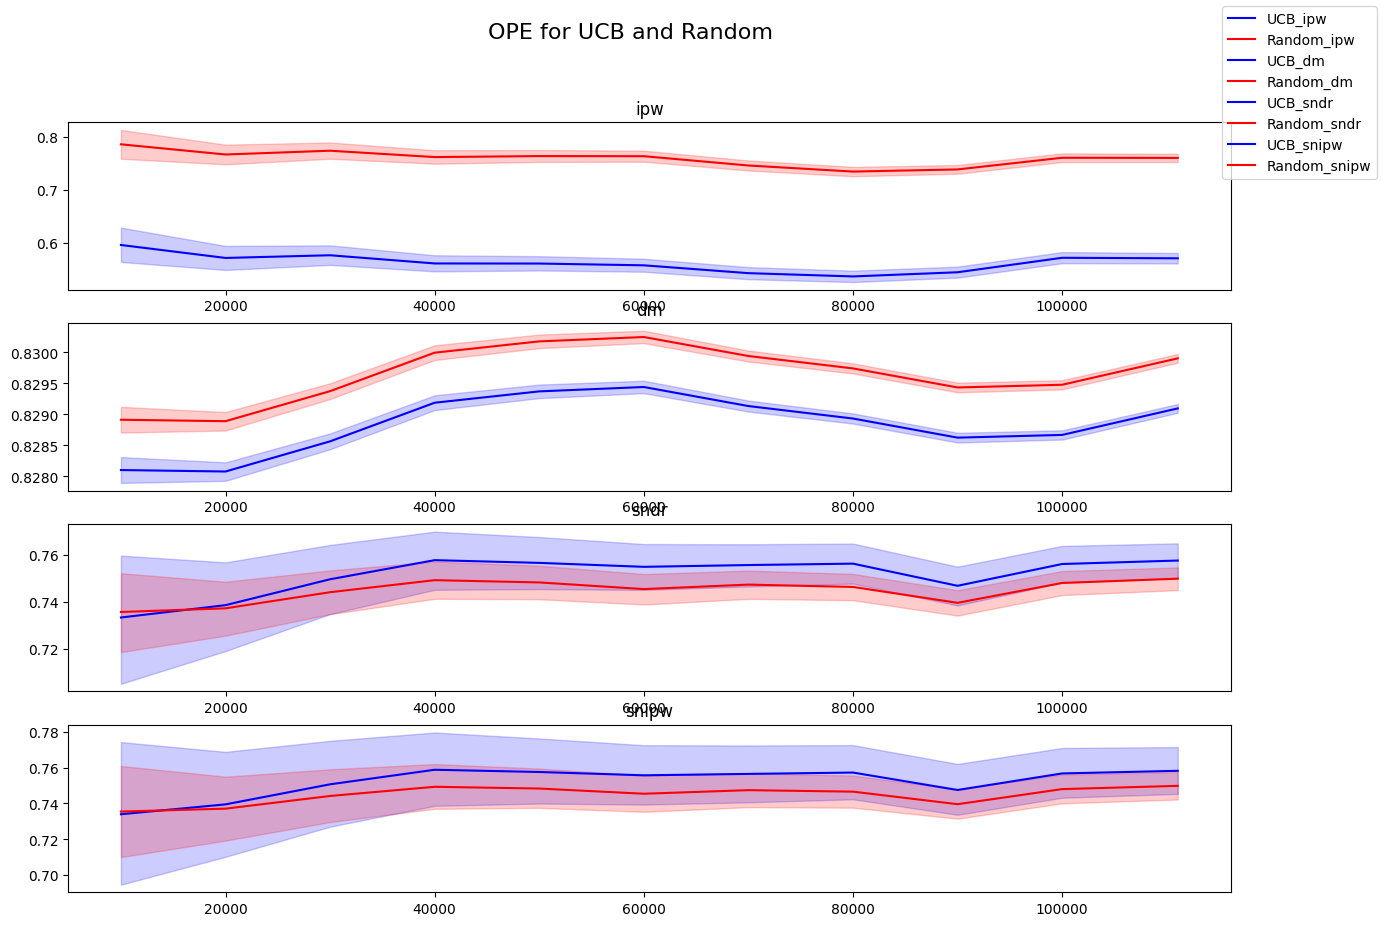

In [34]:
plot_res_two_politics(CIs_1, CIs_3, "UCB", "Random")

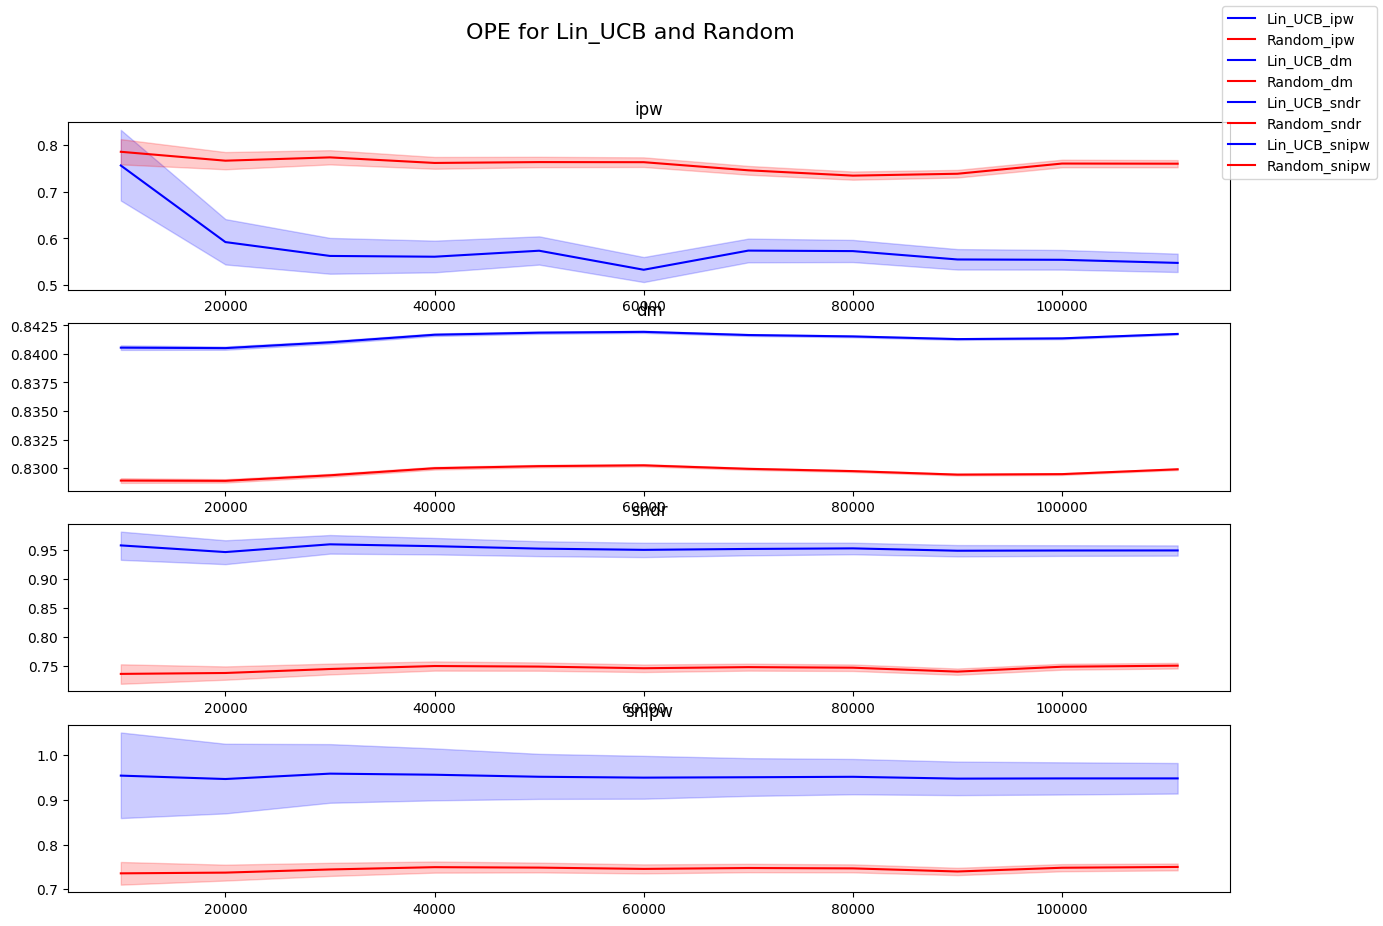

In [35]:
plot_res_two_politics(CIs_2, CIs_3, "Lin_UCB", "Random")

In [37]:
def plot_join_res(Vs, CIs, model):
    fig, ax = plt.subplots(figsize=(10, 10))
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw','dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

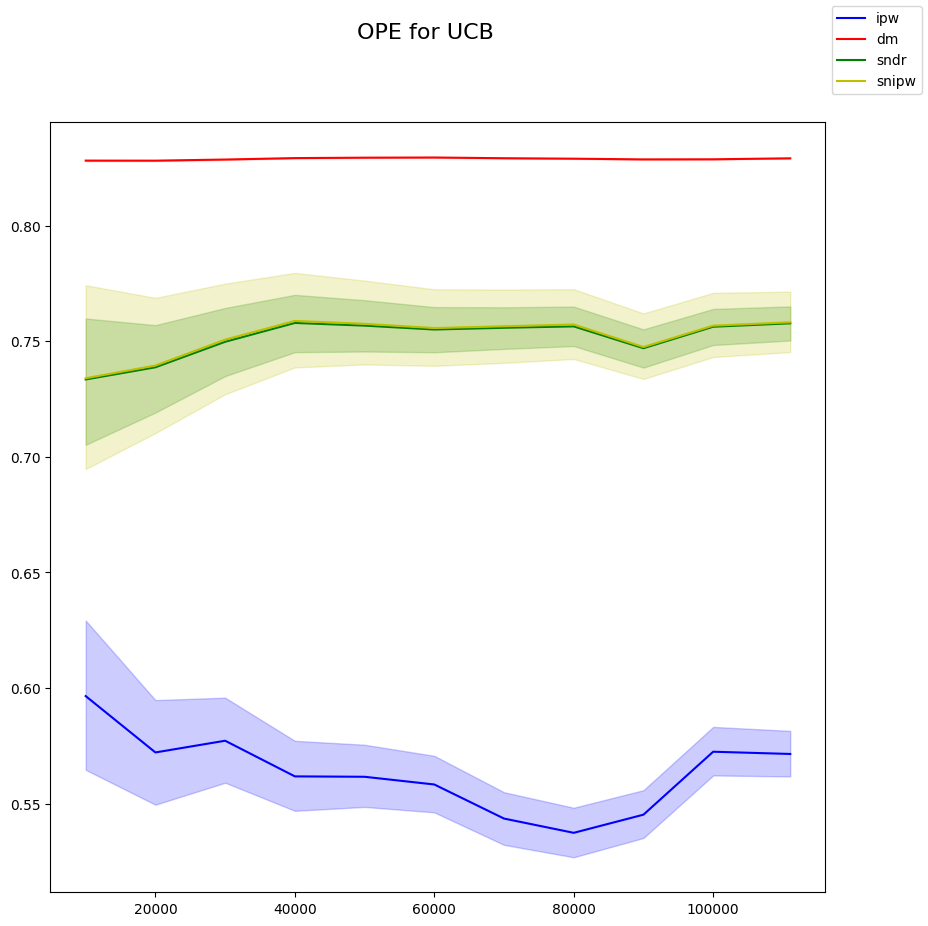

In [38]:
plot_join_res(Vs_1, CIs_1, 'UCB')

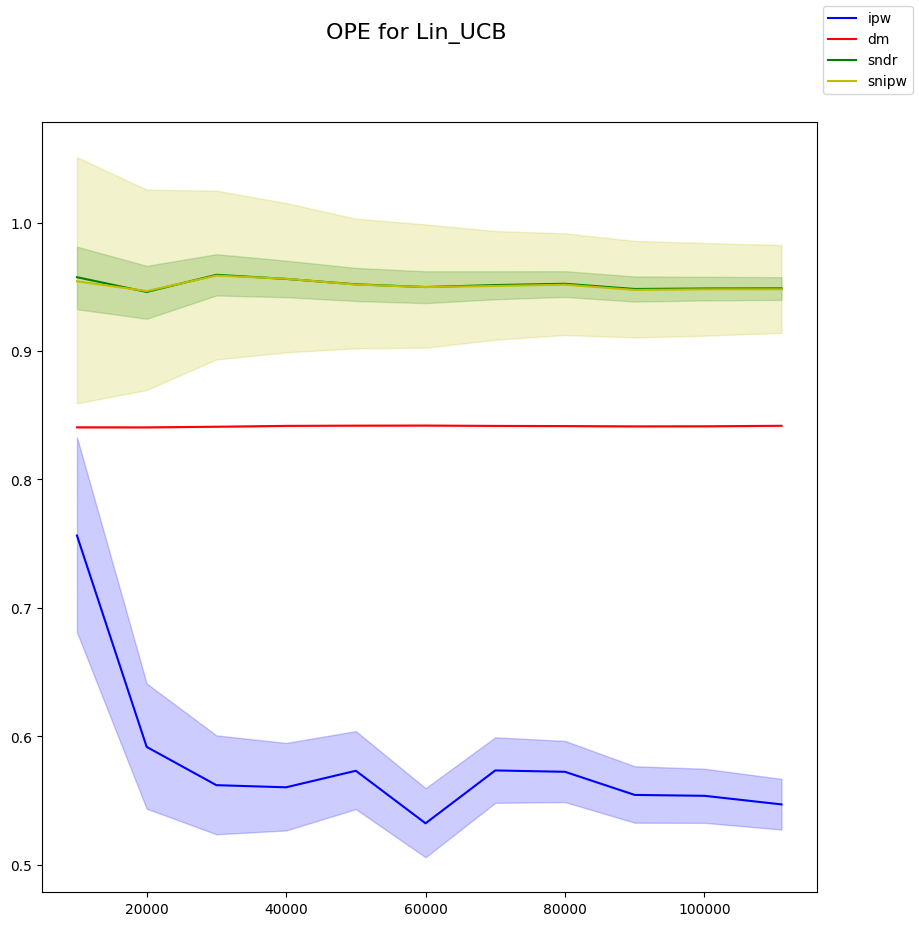

In [39]:
plot_join_res(Vs_2, CIs_2, 'Lin_UCB')

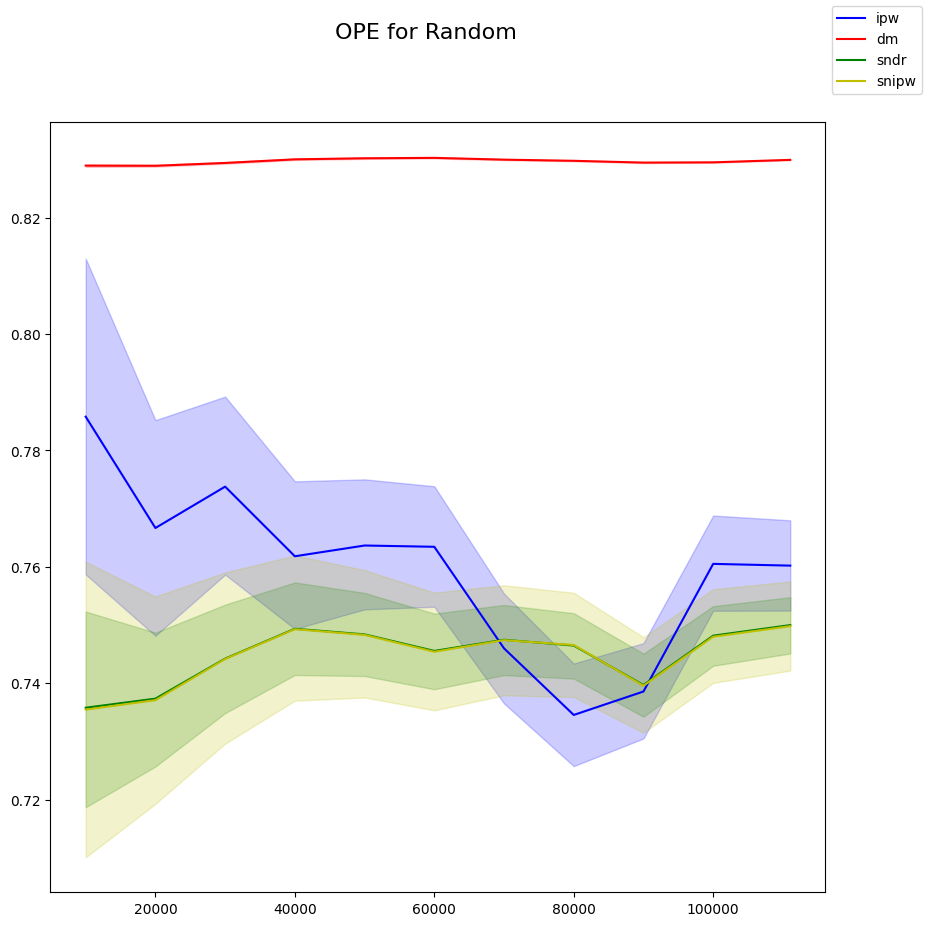

In [40]:
plot_join_res(Vs_3, CIs_3, 'Random')

In [42]:
test_pos_idx = np.where(bandit_feedback_test['reward'] == 1)[0]
test_actions_pos = bandit_feedback_test['action'][test_pos_idx]
test_context_pos = bandit_feedback_test['context'][test_pos_idx]

In [43]:
print("ucb")
learner_1.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 1)

ucb


{'hr@1': 0.0002092418836174618,
 'mrr@1': 0.0002092418836174618,
 'ndcg@1': 0.0002092418836174618,
 'cov@1': 1.0}

In [44]:
print("Lin_ucb")
learner_2.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 1)

Lin_ucb


{'hr@1': 0.0016629223382229857,
 'mrr@1': 0.0016629223382229857,
 'ndcg@1': 0.0016629223382229857,
 'cov@1': 0.0023177955189286636}

In [45]:
print("Random")
learner_3.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 1)

Random


{'hr@1': 0.0002643055372010044,
 'mrr@1': 0.0002643055372010044,
 'ndcg@1': 0.0002643055372010044,
 'cov@1': 1.0}

In [46]:
print("ucb")
learner_1.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 3)

ucb


{'hr@3': 0.0004184837672349236,
 'mrr@3': 0.00016335550563117634,
 'ndcg@3': 0.00022772529604580326,
 'cov@3': 1.0}

In [47]:
print("Lin_ucb")
learner_2.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 3)

Lin_ucb


{'hr@3': 0.005253072551869961,
 'mrr@3': 0.003160653715695344,
 'ndcg@3': 0.0036944680805440183,
 'cov@3': 0.006438320885912954}

In [48]:
print("Random")
learner_3.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 3)

Random


{'hr@3': 0.0008589929959032642,
 'mrr@3': 0.0005304465295214602,
 'ndcg@3': 0.000614738137833775,
 'cov@3': 1.0}

In [ ]:
ssh hdilab@172.21.136.110 -p 22